# Projeto 2 - Modelagem e Simulação do Mundo Físico

**Alunos: Davi Reis Vieira de Souza | Francisco Pinheiro Janela | Nicolas Maciel Queiroga**

**Objetivo: Implementação de um forno de cozinha.**

**(1) Introdução**

<left><img src="fornoEletrico.png" width=300 style="float: center; margin: 0px 0px 10px 10px"></left>
<left><b>Figura 1: Forno elétrico de cozinha</b></left>

Para uma confeiteira caseira, o forno elétrico é uma das principais máquinas utilizadas para produzir seus produtos. Vamos desenvolver um modelo que represente essa máquina para responder às seguintes perguntas:

- **Qual o tempo necessário para se estabilizar a temperatura escolhida pela confeiteira?**
- **Qual a variação entre a temperatura do vidro e a temperatura interna do forno para cada temperatura escolhida pela confeiteira?**

Para isso, utilizaremos um forno de $46,5cm$ x $37,2cm$ x $42,0cm$. A temperatura de controle e validação será $220 °C$, e as temperaturas escolhidas pelo padeiro serão: $180$, $200$, $220$, $240$, $260$, $280$, $300$, $320$, $340$ e $360$ graus Celsius.

In [1]:
#Importando Bibliotecas para o nosso Projeto
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import math

%matplotlib inline
from ipywidgets import interactive

**(1.1) Obtenção de Dados Experimentais**

Para um tempo de 3 horas, foi medida a temperatura de um forno elétrico usando o visor de temperatura da máquina (indica a temperatura interna do forno) e um termometro para medir a temperatura externa do vidro. Os daddos obtidos foram plotados em um gráfico:

In [2]:
#criando a lista de dados medidos pela equipe do forno eletrico.
def DadosMedidos():    
    listaTempoMedido_min = np.arange(0, 180, 6)
    listaTemperaturaMedida_forno= [25.4,65.8,108.2,141.6,176.0,184.7,203.0,212.8,218.3,218.5,219.2,218.8,219.7,218.4,219.0,219.5,220.2,219.8,219.4,219.7,218.8,219.5,220.0,219.6,219,219.4,219.8,219.6,219.4,220.1]
    listaTemperaturaMedida_vidro= [24,25,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,43,44,45,46,47,47,48,48,49,49,49]
    return listaTempoMedido_min, listaTemperaturaMedida_forno, listaTemperaturaMedida_vidro


**(1.2) Plotando o gráfico com os dados obtidos:** 

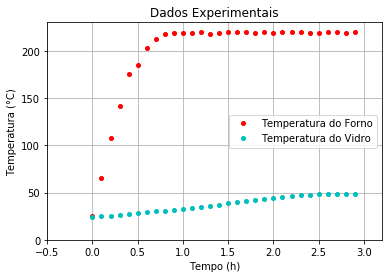

In [3]:
#plotando os dados experimentais medidos pela equipe:
ax=plt.axes()
plt.plot((DadosMedidos()[0]/60), DadosMedidos()[1], 'ro', markersize=4, label='Temperatura do Forno')
plt.plot((DadosMedidos()[0]/60), DadosMedidos()[2], 'co', markersize=4, label='Temperatura do Vidro')
plt.axis([-0.5, (max(DadosMedidos()[0])/60)+0.3, 0, max(DadosMedidos()[1])+10])
plt.xlabel("Tempo (h)")
plt.ylabel("Temperatura (°C)")
plt.title('Dados Experimentais')
plt.legend()
plt.grid(True)
plt.show()



**(2) Modelo inicial:**

Para nosso primeiro modelo, consideramos as paredes perfeitamente isolantes e a única saída de calor é a porta de vidro, composta por um único painel que cobre toda a frente:

<left><img src="modelo_1iteracao.png" width=400 style="float: center; margin: 0px 0px 10px 10px"></left>
<left><b>Figura 2: Sistema térmico do forno de cozinha</b></left>

Depois criamos o modelo de Estoques e Fluxos:

<left><img src="E&F_1iteracao.png" width=800 style="float: center; margin: 0px 0px 10px 10px"> 
    <b>Figura 3: Primeiro modelo de estoques e fluxos</b></left>

Para implementar o modelo por ODEINT, vamos usar as fórmulas abaixo para facilitar o programa:

$\frac{dTar}{dt}=\frac{1}{mar\cdot car}\cdot[\dot{Q_1}-\dot{Q_v}]$

$\frac{dTvidro}{dt}=\frac{1}{mvidro\cdot cvidro}\cdot[\dot{Q_v}-\dot{Q_2}]$

Sendo:

$\dot{Q_1}=P$

$\dot{Q_v}=\frac{Tar-Tvidro}{\frac{dvidro}{kvidro\cdot Avidro}}$

$\dot{Q_2}=\frac{Tvidro-Tamb}{\frac{dvidro}{kvidro\cdot Avidro}+\frac{1}{har\cdot Avidro}}$


Abaixo, inicializamos todos os parâmetros do problema. As unidades estão todas no S.I. para evitar conversões dentro do programa.

In [4]:
#densidade do Ar: 1225 kg/m3
Dar=1225
#densidade do Vidro: 2535 kg/m3
Dvidro=2535  
#volume de Ar (Tamanho do forno utilizado)
Var=46.5*37.2*42.0*1e-6
#Área do painel de vidro (m2)
Avidro=40*25.2*1e-4
#volume da parede de vidro (m3)
Vvidro=Avidro*1.2*1e-2
#massa de Ar (kg)
mar=Dar*Var
#massa do Vidro (kg)
mvidro=Dvidro*Vvidro
#calor específico do Ar: 1004 J/kgK 
car=1004
#calor específico do Vidro:900 J/kgK 
cvidro=900
#temperatura ambiente, em kelvin
Ta=25+273.15
#espessura do painel de vidro: 1.2cm --> 0.012m: vamos dividi-lo ao meio na modelagem da condução térmica
dvidro=0.012/2
#condutividade térmica do Vidro --> 0.8W/mK
kvidro=0.8
#coeficiente de transferência convectiva das paredes do Vidro para o Ambiente --> 2W/m2K
har=2
#potência térmica do Forno --> 7kW
P=7000

**(2.1) Implementando a função que representa as equações diferenciais**

In [5]:
#Função do modelo da 1ª iteração:
def modelo_v1(x,t):
    Tar=x[0]
    Tvidro=x[1]
    Q1=P
    Qv=(Tar-Tvidro)/(dvidro/(kvidro*Avidro))
    Q2=(Tvidro-Ta)/((dvidro/(kvidro*Avidro))+(1/(har*Avidro)))
    dTardt=(Q1-Qv)/(mar*car)
    dTvidrodt=(Qv-Q2)/(mvidro*cvidro)
    dxdt=[dTardt, dTvidrodt]
    return dxdt

**(2.2) Implementação do modelo**

Usando a biblioteca numpy, criamos a lista temporal de 3 horas, considerando um espaçamento temporal de segundo em segundo. Considerando a temperatura ambiente como variável inicial dos estoques, gerando o gráfico com ODEINT, temos:

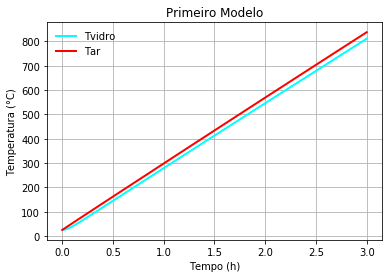

In [6]:
delta_t=1
lista_tempo = np.arange(0, 10800, delta_t)
x_0=[Ta, Ta]

x=odeint(modelo_v1, x_0, lista_tempo)

lista_Tar_celsius=[temp-273.15 for temp in x[:,0]]
lista_Tvidro_celsius=[temp-273.15 for temp in x[:,1]]
lista_tempo_horas=[t/3600 for t in lista_tempo]

ax=plt.axes()
plt.plot(lista_tempo_horas, lista_Tvidro_celsius, color='cyan', linewidth=2, label='Tvidro')
plt.plot(lista_tempo_horas, lista_Tar_celsius, color='red', linewidth=2, label='Tar')
plt.title('Primeiro Modelo')
plt.ylabel("Temperatura (°C)")
plt.xlabel("Tempo (h)")
plt.legend(framealpha=False)
plt.grid(True)

**(3) Primeira Iteração**

Ao revisar o modelo, vamos implementar 2 mudanças para a primeira iteração: vamos considerar as paredes do forno (as laterais, em cima e atrás) compostas de uma placa de fibra de cerâmica revestidas por placas finas de aço (estética) e que haverá o input de temperatura que a confeiteira vai utilizar.

<left><img src="modelo_2iteracao.png" width=400 style="float: center; margin: 0px 0px 10px 10px"></left>
<left><b>Figura 4: 1ª iteração do sistema térmico do forno de cozinha</b></left>

Abaixo, temos o diagrama de estoques e fluxos, onde Tuser é o input de temperatura do forno:

<left><img src="E&F_2iteracao.png" width=800 style="float: center; margin: 0px 0px 10px 10px"> 
<b>Figura 5: Modelo de estoques e fluxos da primeira iteração</b></left>

Para facilitar a implementação, as equações que representam a iteração: 

$\frac{dTar}{dt}=\frac{1}{mar\cdot car}\cdot[\dot{Q_1}-\dot{Q_v}-\dot{Q_s}]$

$\frac{dTvidro}{dt}=\frac{1}{mvidro\cdot cvidro}\cdot[\dot{Q_v}-\dot{Q_2}]$

Sendo:

$\dot{Q_1}=P$, para Tar < Tuser-30

$\dot{Q_1}=P*1-\frac{Tar-(Tuser-30)}{30}$, para Tar >= Tuser-30

$\dot{Q_v}=\frac{Tar-Tvidro}{\frac{\frac{dvidro}{2}}{kvidro\cdot Avidro}}$

$\dot{Q_s}=\frac{Tar-Tamb}{\frac{2*daco}{kaco\cdot At}+\frac{dceramica}{kceramica\cdot At}+\frac{1}{har\cdot At}}$

$\dot{Q_2}=\frac{Tvidro-Tamb}{\frac{\frac{dvidro}{2}}{kvidro\cdot Avidro}+\frac{1}{har\cdot Avidro}}$


Adicionando, então, os novos parâmetros do modelo temos:

In [7]:
#condutividade térmica do Aço --> 52W/mK
kaco=52
#condutividade térmica da Fibra de Cerâmica --> 0.08W/mK
kceramica=0.08
#espessura do Aço: 0.4cm --> 0.004m
daco=0.004
#espessura da fibra de Cerâmica: 5.0cm --> 0.05m
dceramica=0.05
#Área Total (m2)
At=(2*46.5*37.2 + 46.5*42.0 + 37.2*42.0)*1e-4

**(3.1) Implementando a função que representa as equações diferenciais para a primeira iteração**

In [8]:
def funcaocontrolepot(Tar,temp_user):
    #print(Tar,temp_user)
    pot = 1
    if Tar>=temp_user:
        pot=0
    elif Tar>temp_user-30:
        pot=1-(((Tar)-(temp_user-30))/30)
    else:
        pot = 1
    return pot

def modelo_v2(x,t,temp_user):
    temp_user+=273.15
    Tar=x[0]
    Tvidro=x[1]
    Q1=P*float(funcaocontrolepot(Tar,temp_user))
    #Q1=P
    Qv=(Tar-Tvidro)/(dvidro/(kvidro*Avidro))
    Q2=(Tvidro-Ta)/((dvidro/(kvidro*Avidro))+(1/(har*Avidro)))
    Qs=(Tar-Ta)/((2*daco/(kaco*At))+(dceramica/(kceramica*At))+(1/(har*At)))
    dTardt=(Q1-Qv-Qs)/(mar*car)
    dTvidrodt=(Qv-Q2)/(mvidro*cvidro)
    dxdt=[dTardt, dTvidrodt]
    return dxdt

**(3.2) Implementação a 1ª iteração**

Com a capacidade de interagir com o gráfico variando a temperatura escolhida pela confeiteira, implementamos a 1ª iteração do modelo para as temperaturas disponíveis.


In [9]:
#rodando Odeint:
def f(Temperatura):   
    x=odeint(modelo_v2,x_0,lista_tempo,args=(Temperatura,))

    lista_Tar_celsius=[temp-273.15 for temp in x[:,0]]
    lista_Tvidro_celsius=[temp-273.15 for temp in x[:,1]]
    lista_tempo_horas=[t/3600 for t in lista_tempo]

    graficoTar=plt.plot(lista_tempo_horas, lista_Tar_celsius)
    plt.setp(graficoTar,linewidth=1,color='r',label='Temperatura do Ar')
    graficoTvidro=plt.plot(lista_tempo_horas, lista_Tvidro_celsius)
    plt.setp(graficoTvidro,linewidth=1,color='c', label='Temperatura do Vidro')
    plt.title('Variação da Temperatura pelo Tempo - Usuário escolheu: {0} °C'.format(Temperatura))
    plt.xlabel("Tempo (h)")
    plt.ylabel("Temperatura (°C)")
    plt.yticks([0,50,100,150,200,250,300,350,400])
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
interactive_plot = interactive(f,Temperatura=(180,360,20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=260, description='Temperatura', max=360, min=180, step=20), Output(layou…

**(4) Segunda Iteração** 

Na segunda iteração foi percebida uma perda de calor considerável pela área do vidro. Para resolver essa incoerência, utilizaremos um sistema de duplos paineis de vidro com um gas inerte entre eles. O gás escolhido será o Argônio, tipicamente conhecido por suas capacidades de isolamento nesse contexto, e utilizado largamente pela indústria para construção de paineis de vidro duplo. Além disso, foi considerado o fluxo de convexção do ar dentro do forno até a porta de vidro. Assim, remodelando nosso esquema, considerando o estoque do vidro como sendo o painel em contato com o ar, temos:

<left><img src="modelo_3iteracao.png" width=400 style="float: center; margin: 0px 0px 10px 10px"></left>
<left><b>Figura 6: 3ª iteração do sistema térmico do forno de cozinha</b></left>

Adicionando a condutividade térmica dos gases no nosso sistema de estoques e fluxos, temos:

<left><img src="E&F_3iteracao.png" width=800 style="float: center; margin: 0px 0px 10px 10px"> 
<b>Figura 7: Modelo de estoques e fluxos da terceira iteração</b></left>

Para facilitar a implementação, as equações que representam a iteração: 

$\frac{dTar}{dt}=\frac{1}{mar\cdot car}\cdot[\dot{Q_1}-\dot{Q_v}-\dot{Q_s}]$

$\frac{dTvidro}{dt}=\frac{1}{mvidro\cdot cvidro}\cdot[\dot{Q_v}-\dot{Q_2}]$

Sendo:

$\dot{Q_1}=P$, para Tar < Tuser-30

$\dot{Q_1}=P\cdot(1-\frac{Tar-(Tuser-30)}{30})$, para Tar >= Tuser-30

$\dot{Q_v}=\frac{Tar-Tvidro}{\frac{1}{har\cdot Avidro}+\frac{dvidro}{kvidro\cdot Avidro}+\frac{1}{hargon\cdot Avidro}+\frac{\frac{dvidro}{2}}{kvidro\cdot Avidro}}$

$\dot{Q_s}=\frac{Tar-Tamb}{\frac{2*daco}{kaco\cdot At}+\frac{dceramica}{kceramica\cdot At}+\frac{1}{har\cdot At}}$

$\dot{Q_2}=\frac{Tvidro-Tamb}{\frac{\frac{dvidro}{2}}{kvidro\cdot Avidro}+\frac{1}{har\cdot Avidro}}$


Para esta iteração, foram adicionados e modificados os seguintes parametros:

In [10]:
#convecção térmica do gás Árgonio --> 22mW/mK
hargon=2
#espessura do painel de vidro: 5mm --> 0.005m
dvidro=0.005
#Área do painel de vidro (m2)
Avidro=40*25.2*1e-4
#espessura do espaço do gás: 1cm --> 0.01m:
dargon=0.01
#Área do espaço interno para o gás é a mesma do vidro


**(4.1) Implementando a função que representa as equações diferenciais para a primeira iteração**

In [11]:
def funcaocontrolepot(Tar,temp_user):
    #print(Tar,temp_user)
    pot = 1
    if Tar>=temp_user:
        pot=0
    elif Tar>temp_user-30:
        pot=1-(((Tar)-(temp_user-30))/30)
    else:
        pot = 1
    return pot

def modelo_v3(x,t,temp_user):
    temp_user+=273.15
    Tar=x[0]
    Tvidro=x[1]
    Q1=P*float(funcaocontrolepot(Tar,temp_user))
    #Q1=P
    Qv=(Tar-Tvidro)/((1/(har*Avidro))+(dvidro/(kvidro*Avidro))+(1/(hargon*Avidro))+((dvidro/2)/(kvidro*Avidro)))
    Q2=(Tvidro-Ta)/(((dvidro/2)/(kvidro*Avidro))+(1/(har*Avidro)))
    Qs=(Tar-Ta)/((2*daco/(kaco*At))+(dceramica/(kceramica*At))+(1/(har*At)))
    dTardt=(Q1-Qv-Qs)/(mar*car)
    dTvidrodt=(Qv-Q2)/(mvidro*cvidro)
    dxdt=[dTardt, dTvidrodt]
    return dxdt

**(4.2) Implementação a 2ª iteração**

In [12]:
#rodando Odeint:
def f(Temperatura):   
    x=odeint(modelo_v3,x_0,lista_tempo,args=(Temperatura,))

    lista_Tar_celsius=[temp-273.15 for temp in x[:,0]]
    lista_Tvidro_celsius=[temp-273.15 for temp in x[:,1]]
    lista_tempo_horas=[t/3600 for t in lista_tempo]

    graficoTar=plt.plot(lista_tempo_horas, lista_Tar_celsius)
    plt.setp(graficoTar,linewidth=1,color='r',label='Temperatura do Ar')
    graficoTvidro=plt.plot(lista_tempo_horas, lista_Tvidro_celsius)
    plt.setp(graficoTvidro,linewidth=1,color='c', label='Temperatura do Vidro')
    plt.title('Variação da Temperatura pelo Tempo - Usuário escolheu: {0} °C'.format(Temperatura))
    plt.xlabel("Tempo (h)")
    plt.ylabel("Temperatura (°C)")
    plt.yticks([0,50,100,150,200,250,300,350,400])
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
interactive_plot = interactive(f,Temperatura=(180,360,20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=260, description='Temperatura', max=360, min=180, step=20), Output(layou…

**(5) Validação dos resultados** 

Com o nosso modelo refinado, vamos compará-lo com os dados medidos do forno para validação:

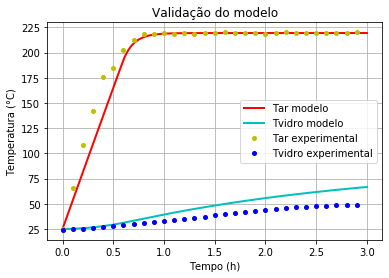

In [13]:
x=odeint(modelo_v3,x_0,lista_tempo,args=(220,))
Tar_modelo=[temp-273.15 for temp in x[:,0]]
Tvidro_modelo=[temp-273.15 for temp in x[:,1]]

ax=plt.axes()
plt.plot(lista_tempo_horas, Tar_modelo, 'r', linewidth=2, label='Tar modelo')
plt.plot(lista_tempo_horas, Tvidro_modelo, 'c', linewidth=2, label='Tvidro modelo')
plt.plot((DadosMedidos()[0]/60), DadosMedidos()[1], 'yo', markersize=4, label='Tar experimental')
plt.plot((DadosMedidos()[0]/60), DadosMedidos()[2], 'bo', markersize=4, label='Tvidro experimental')
plt.xlabel("Tempo (h)")
plt.ylabel("Temperatura (°C)")
plt.title('Validação do modelo')
plt.legend()
plt.grid(True)
plt.show()

**(5.1) Conclusão da Validação**
- Os dados experimentais da temperatura interna do forno validam o modelo, uma vez que se aproximam da linha plotada.


- A divergência relativa à temperatura do vidro se deve por termos utilizado o termômetro em sua parte externa pois não havia a possibilidade de se colocar no interior do painel externo.

**(6) Respondendo às perguntas:**

Com o modelo validado, podemos responder às perguntas que iniciaram o projeto:

- **Qual o tempo necessário para se estabilizar a temperatura escolhida pela confeiteira?**
- **Qual a variação entre a temperatura do vidro e a temperatura interna do forno para cada temperatura escolhida pela confeiteira?**

Utilizando gráficos conclusivos, as respostas foram plotadas, gerando gráficos lineares coerentes.

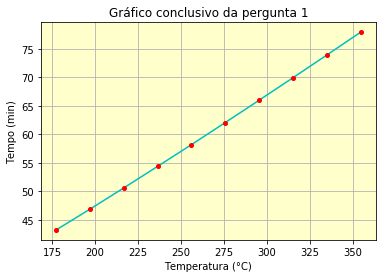

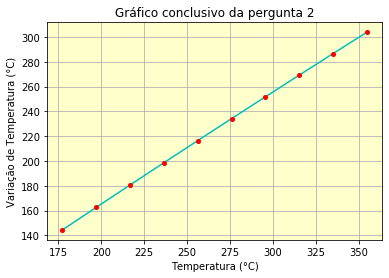

In [14]:
#pergunta 1:
Temperatura_user=[180,200,220,240,260,280,300,320,340,360]
tempo_estavel_seg=[]
tempo_estavel=[]
temperatura_estavel=[]

for Tuser in Temperatura_user:
    x=odeint(modelo_v3,x_0,lista_tempo,args=(Tuser,))
    lista_Tar_celsius=[temp-273.15 for temp in x[:,0]]
    Testavel=0.015*Tuser
    for i in range(len(lista_tempo)):
        if lista_Tar_celsius[i]>Tuser-Testavel:
            tempo_estavel_seg.append(lista_tempo[i])
            tempo_estavel.append(lista_tempo[i]/60)
            temperatura_estavel.append(lista_Tar_celsius[i])
            break

ax=plt.axes()
plt.plot(temperatura_estavel, tempo_estavel, 'c')
plt.plot(temperatura_estavel, tempo_estavel, 'ro', markersize=4)
ax.set_facecolor('xkcd:ivory')
plt.xlabel("Temperatura (°C)")
plt.ylabel("Tempo (min)")
plt.title('Gráfico conclusivo da pergunta 1')
plt.grid(True)
plt.show()


#pergunta 2:
delta_Temperatura=[]
Temperatura_Forno=[]

for j in range(len(Temperatura_user)):
    x=odeint(modelo_v3,x_0,lista_tempo,args=(Temperatura_user[j],))
    lista_Tvidro_celsius=[temp-273.15 for temp in x[:,1]]
    Testavel=tempo_estavel_seg[j]
    deltaT=temperatura_estavel[j]-lista_Tvidro_celsius[Testavel-1]
    delta_Temperatura.append(deltaT)
    
ax=plt.axes()
plt.plot(temperatura_estavel, delta_Temperatura, 'c')
plt.plot(temperatura_estavel, delta_Temperatura, 'ro', markersize=4)
ax.set_facecolor('xkcd:ivory')
plt.xlabel("Temperatura (°C)")
plt.ylabel("Variação de Temperatura (°C)")
plt.title('Gráfico conclusivo da pergunta 2')
plt.grid(True)
plt.show()